<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Dataforst%C3%A5else-og-unders%C3%B8kelse-Pradeep/Bioco_Dataprosessering%2C_Dataforst%C3%A5else_og_Dataunders%C3%B8kelse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataforståelse og Dataundersøkelse

Lasting av nødvendige bibiotek og pakker

In [1]:
!pip install hoggorm
!pip install hoggormPlot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 kB 1.5 MB/s eta 0:00:00


Importering av nødvendige bibliotek og pakker

In [2]:
import pandas as pd
import numpy as np

import copy
import datetime

import hoggorm as ho
import hoggormplot as hop

import seaborn as sns
import matplotlib.pyplot as plt

Importering av data og omgjøring til DataFrame

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
bioco_rå_data = pd.read_csv('/content/drive/MyDrive/MasterV24/BiocoData.csv',
                            header=0,
                            sep=';',
                            index_col=0)

Mounted at /content/drive


Formattering av datasett før videre undersøkelse

In [4]:
# Gjør om index med dato og tid til riktig format
bioco_rå_data.index = pd.to_datetime(bioco_rå_data.index,
                                     format='%d-%m-%Y %H:%M:%S.%f')

Sjekking av kontinuitet i tidsereidata

In [22]:
# Lager lister for å lagre start- og slutttidspunkt på kontinuerlige tidserier
tid_observasjon_start = list()
tid_observasjon_slutt = list ()

# Legger til første observasjon i listen med startstider
tid_observasjon_start.append(bioco_rå_data.index[0])

# Går igjennom datasettet og lagrer slutt- og startstid på tidsintervaller
# mer enn et minutt
for i in range(1, len(bioco_rå_data.index)):
  tidsdiff = bioco_rå_data.index[i] - bioco_rå_data.index[i-1]
  if tidsdiff.total_seconds() > 60:
    tid_observasjon_slutt.append(bioco_rå_data.index[i-1])
    tid_observasjon_start.append(bioco_rå_data.index[i])

# Legger til siste observasjonstid i datasettet
tid_observasjon_slutt.append(bioco_rå_data.index[-1])

# Får oversikt over kontinuerlige datasett
for i,j in zip(tid_observasjon_start, tid_observasjon_slutt):
  i_week = i.isocalendar().week
  print("Uke {}: Tidsintervallet {} til {}"
        "er kontinuerlig tidserie".format(i_week, i, j))

Uke 44: Tidsintervallet 2022-10-31 15:30:00 til 2022-11-02 05:19:00er kontinuerlig tidserie
Uke 44: Tidsintervallet 2022-11-02 10:47:00 til 2022-11-05 00:04:00er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-07 16:24:00 til 2022-11-08 23:57:00er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 01:39:00 til 2022-11-09 06:37:00er kontinuerlig tidserie
Uke 45: Tidsintervallet 2022-11-09 11:11:00 til 2022-11-12 03:59:00er kontinuerlig tidserie
Uke 46: Tidsintervallet 2022-11-14 18:01:00 til 2022-11-18 06:15:00er kontinuerlig tidserie
Uke 46: Tidsintervallet 2022-11-18 08:45:00 til 2022-11-19 03:44:00er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-21 16:23:00 til 2022-11-23 06:05:00er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-23 08:59:00 til 2022-11-23 13:59:00er kontinuerlig tidserie
Uke 47: Tidsintervallet 2022-11-23 20:15:00 til 2022-11-26 00:49:00er kontinuerlig tidserie
Uke 48: Tidsintervallet 2022-11-28 14:38:00 til 2022-11-30 04:29:00er kontinuerl

Informasjon om bioco rådata

In [6]:
bioco_rå_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EnzymeCode        43251 non-null  object 
 1   RawMatFlow        43196 non-null  float64
 2   WaterFlow         43196 non-null  float64
 3   RawMatPercent     43196 non-null  float64
 4   RawMaterialMix    43251 non-null  object 
 5   NIRfat            29064 non-null  float64
 6   NIRprotein        27520 non-null  float64
 7   NIRash            29275 non-null  float64
 8   NIRwater          29293 non-null  float64
 9   TT07              43201 non-null  float64
 10  TT08              43206 non-null  float64
 11  PT03              43226 non-null  float64
 12  TT20              43226 non-null  float64
 13  TT09              43236 non-null  float64
 14  TT12              43251 non-null  float64
 15  product_sampleID  540 non-null    object 
 16  Colla

Fordelingen i Enzymtyper

In [20]:
# Fordelingen i "EnzymeCode"

frekvens = bioco_rå_data['EnzymeCode'].value_counts()
andel = bioco_rå_data['EnzymeCode'].value_counts(normalize=True) * 100

enzymtyper_data = pd.DataFrame({
    'Frekvens': frekvens,
    'Andel': andel
})

print(enzymtyper_data)

    Frekvens      Andel
A2     29213  67.542947
A1      5482  12.674851
D       2272   5.253058
B       2270   5.248434
C       2080   4.809137
E       1934   4.471573


Fordelingen i Råmaterialetype

In [21]:
# Fordelingen i "RawMaterialMix"

frekvens = bioco_rå_data['RawMaterialMix'].value_counts()
andel = bioco_rå_data['RawMaterialMix'].value_counts(normalize=True) * 100

råmateriale_data = pd.DataFrame({
    'Frekvens': frekvens,
    'Andel': andel
})

print(råmateriale_data)

             Frekvens      Andel
Unknown mix     42607  98.511017
Turkey            355   0.820790
Chicken           289   0.668193


Utelukking av kolonner i datasett før videre undersøkelse

In [49]:
# Dropper kolonner "product_SampleID" og "testset" som ikke er relevant
bioco_data = bioco_rå_data.drop(columns=['product_sampleID', 'testset'])

# Dropper "RawMaterialMix", da det meste av datasettet består av Unknown mix
bioco_data.drop(columns=['RawMaterialMix'],
                inplace=True)

# Dropper kolonner "Brix", "Yield" og "Yield_withoutNIR", da "BrixAdjusted"
# dekker samme informasjon
bioco_data.drop(columns=['Brix', 'Yield', 'Yield_withoutNIR'],
                inplace=True)

Behandling av kategorisk variabel "EnzymeCode"

In [50]:
# Koverterer "EnzymeCode" fra kategorisk variabel til numeriske varaibler for
# hver respektive enzymtype
bioco_data = pd.get_dummies(bioco_data,
                            columns=["EnzymeCode"],
                            prefix=["EnzymeType"] )

# Reorgoniserer kolonnene, slik at enzymtype-informasjonen er de fremste
kolonne_rekkefølge = (bioco_data.columns[-6:].to_list() +
                      bioco_data.columns[:-6].to_list())
bioco_data = bioco_data[kolonne_rekkefølge]

Informasjon om førbehandlet datasett

In [51]:
bioco_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   43251 non-null  uint8  
 1   EnzymeType_A2   43251 non-null  uint8  
 2   EnzymeType_B    43251 non-null  uint8  
 3   EnzymeType_C    43251 non-null  uint8  
 4   EnzymeType_D    43251 non-null  uint8  
 5   EnzymeType_E    43251 non-null  uint8  
 6   RawMatFlow      43196 non-null  float64
 7   WaterFlow       43196 non-null  float64
 8   RawMatPercent   43196 non-null  float64
 9   NIRfat          29064 non-null  float64
 10  NIRprotein      27520 non-null  float64
 11  NIRash          29275 non-null  float64
 12  NIRwater        29293 non-null  float64
 13  TT07            43201 non-null  float64
 14  TT08            43206 non-null  float64
 15  PT03            43226 non-null  float64
 16  TT20            43226 non-null  float64
 

# Datafordeling

## Fordeling i hele datasett

Lager kopi av datasett for merinformasjon om tidsintervaller som dag og uke

In [27]:
bioco_data_tid = copy.deepcopy(bioco_data)
bioco_data_tid['Week'] = bioco_data_tid.index.week
bioco_data_tid['Day'] = (bioco_data_tid.index.weekday + 1)

<ipython-input-27-06882f1e5404>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  bioco_data_tid['Week'] = bioco_data_tid.index.week


Fordeling i variablene for hele datasettet med uke- og dagsinformasjon

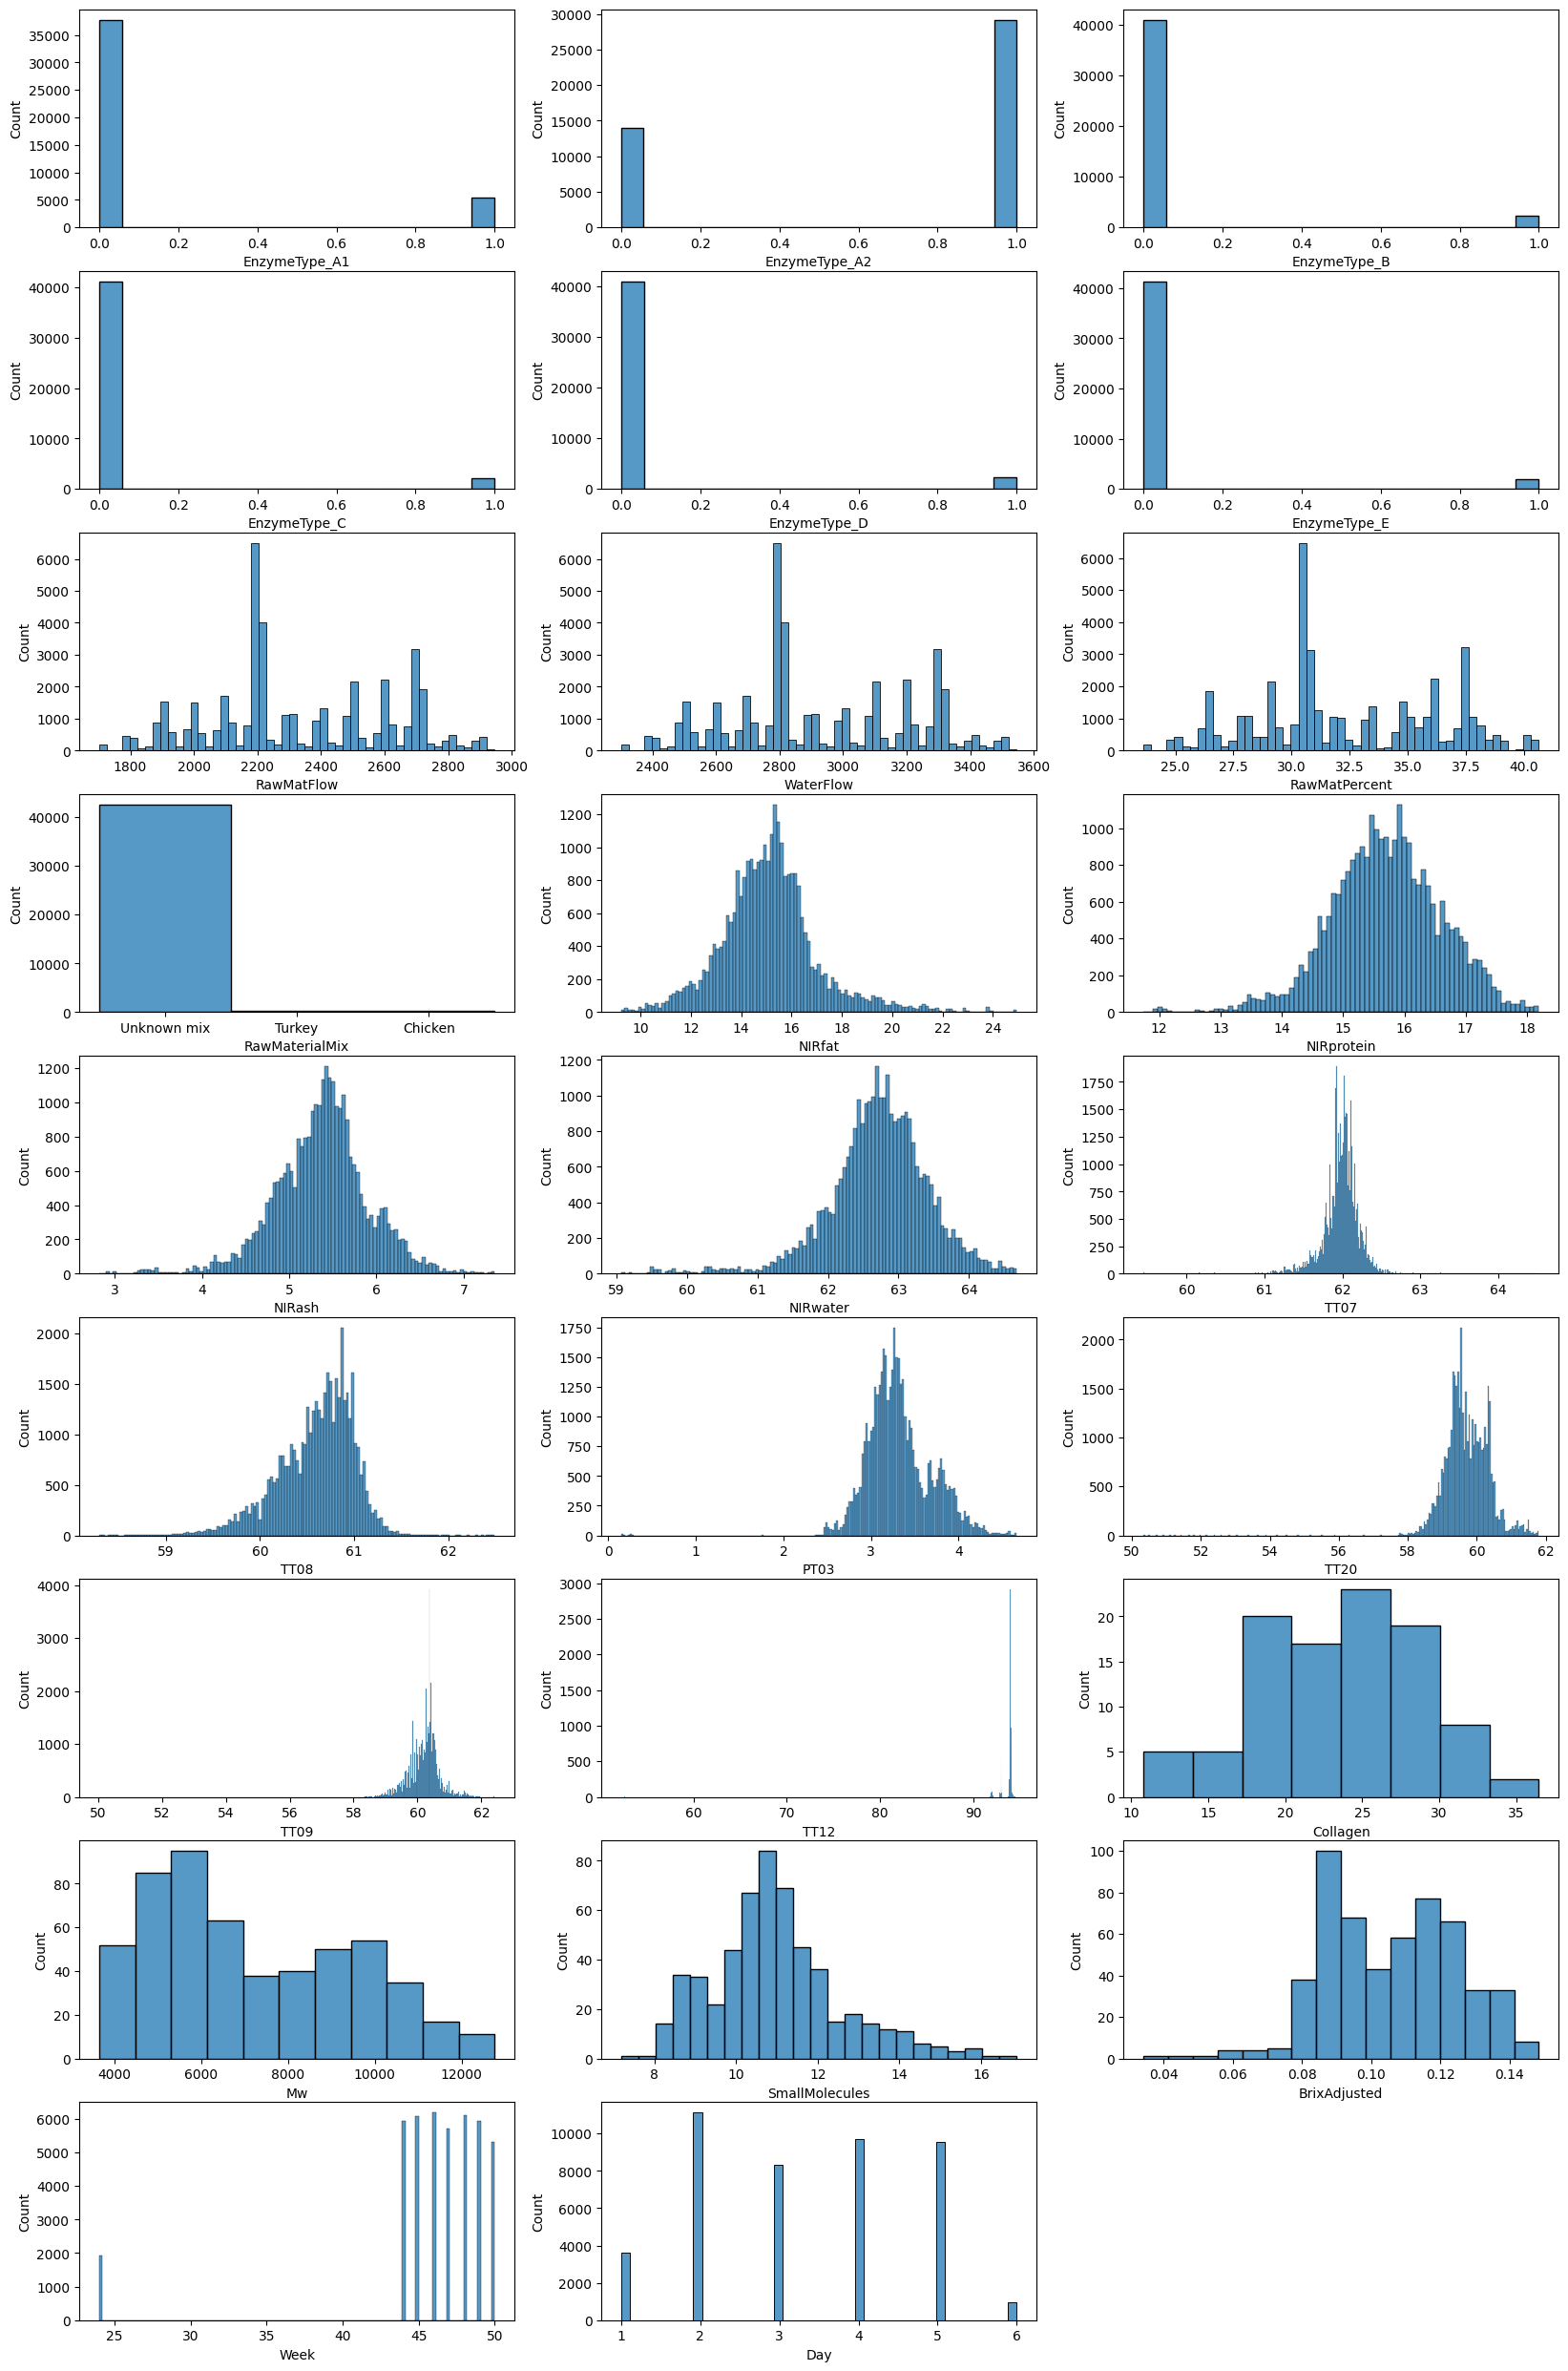

In [40]:
fig = plt.figure(figsize=(20,35))
antall_kolonnner = len(bioco_data_tid.columns)
rute_nett = fig.add_gridspec(10,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), bioco_data_tid):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = bioco_data_tid)
  i += 1

## Fordeling i markert del av datasett

Datasett for markert del av hele datasett

In [29]:
# Lager et datasett for Collagen med mindre markeringer enn resterende kvalitesmålinger
collagen_markert = bioco_data_tid.dropna(subset=['Collagen'])

# Lager et datasett for de resterende kvalitetsmålinger
kvalitetsmålinger_markert = bioco_data_tid.dropna(subset=['Mw',
                                                          'SmallMolecules',
                                                          'BrixAdjusted'])

Fordeling i datasett med Collagen som markert respons

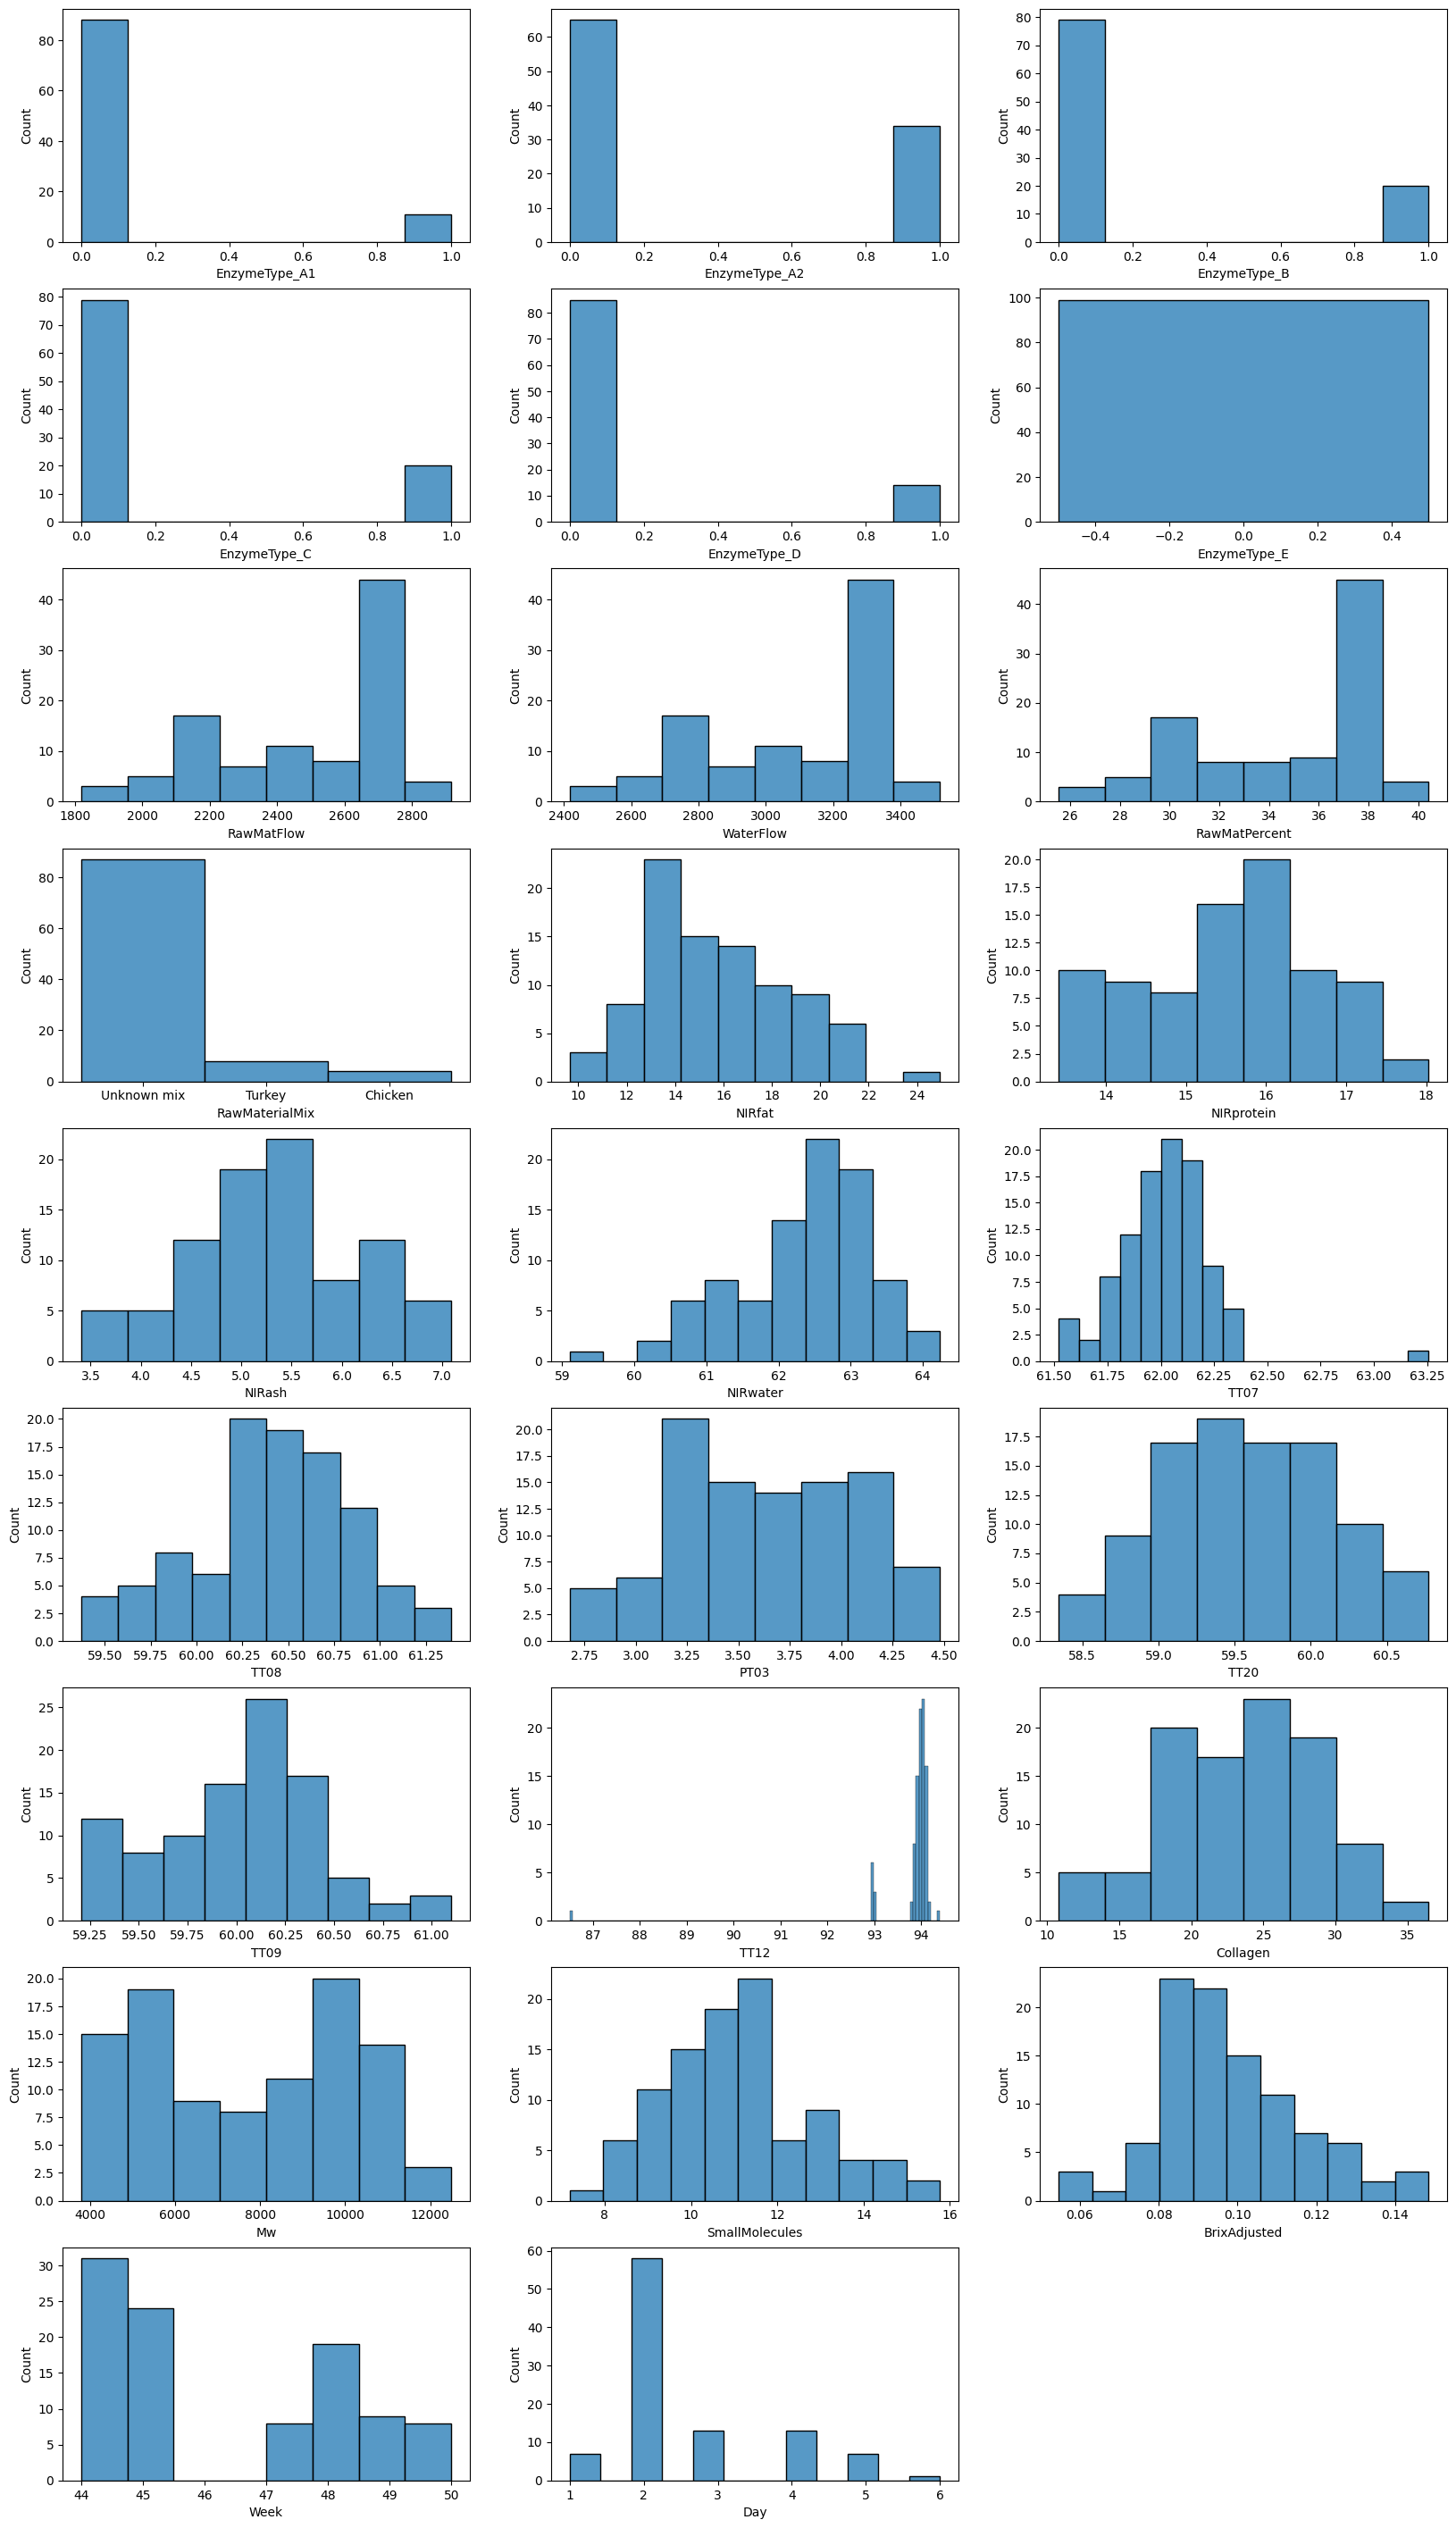

In [32]:
fig = plt.figure(figsize=(20,35))
antall_kolonnner = len(collagen_markert.columns)
rute_nett = fig.add_gridspec(10,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), collagen_markert):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = collagen_markert)
  i += 1

Fordeling i datasett med resterende kvalitetsmålinger som markert respons

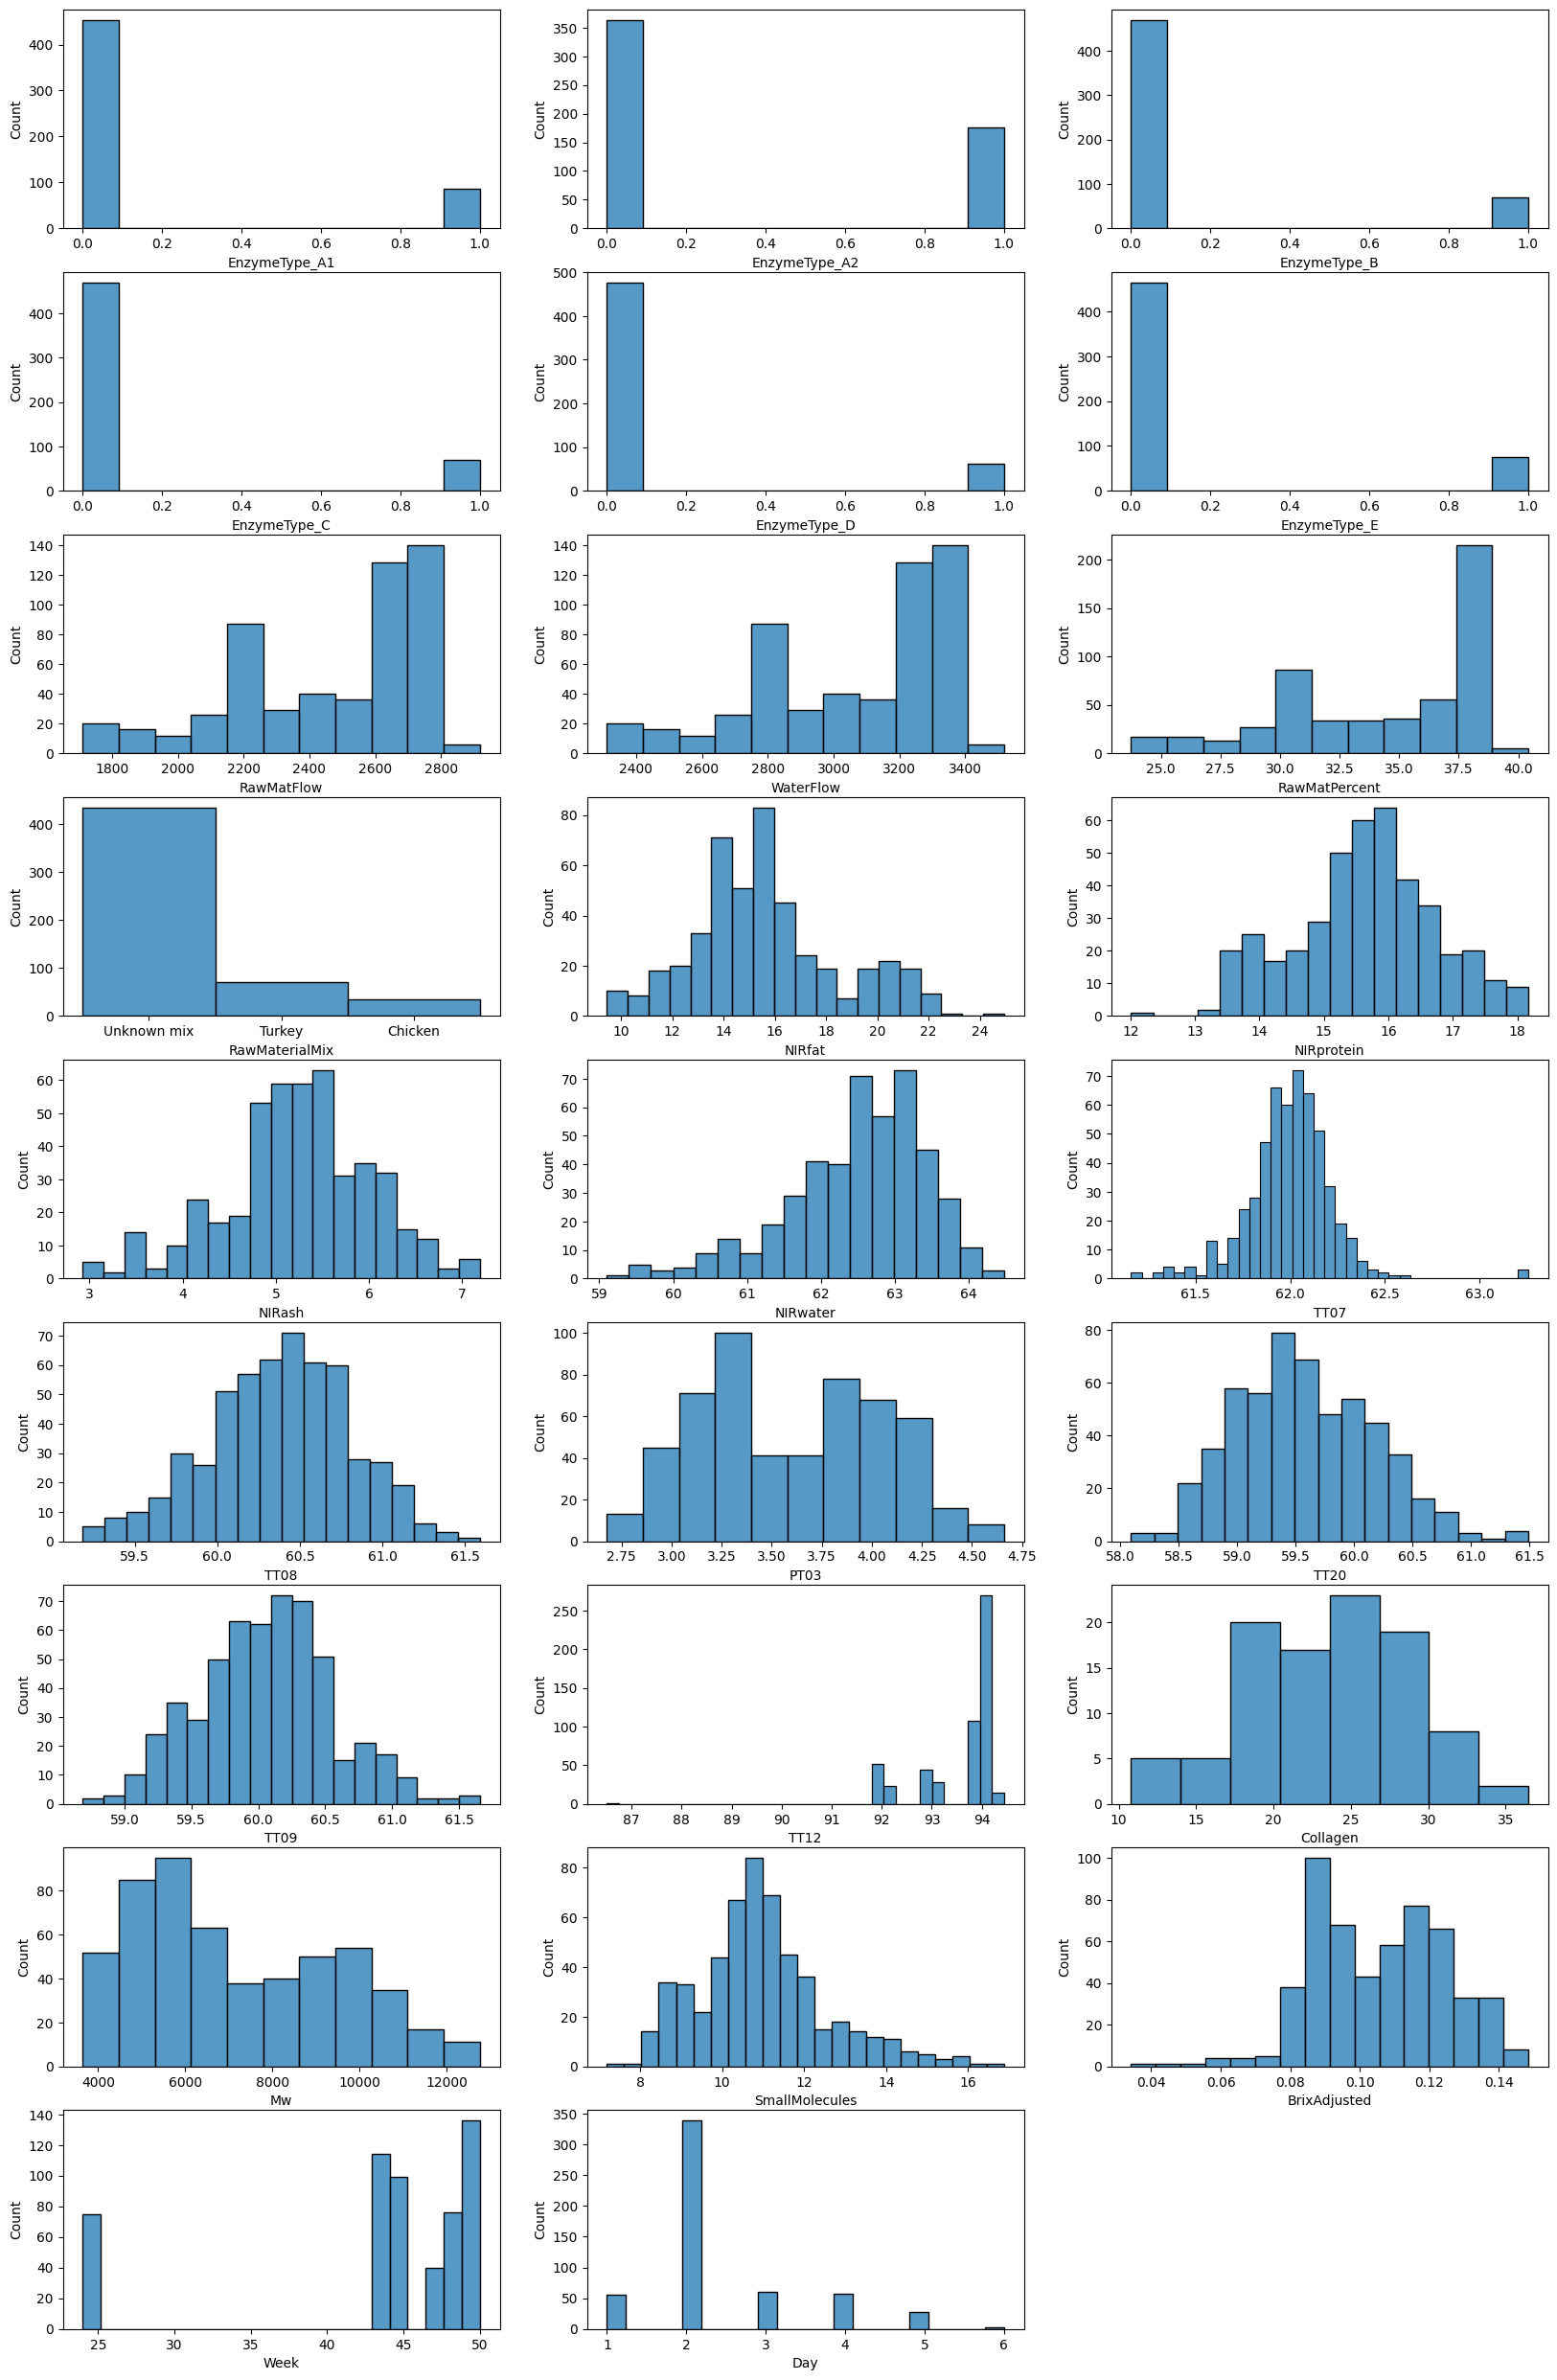

In [33]:
fig = plt.figure(figsize=(20,35))
antall_kolonnner = len(kvalitetsmålinger_markert.columns)
rute_nett = fig.add_gridspec(10,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), kvalitetsmålinger_markert):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.histplot(x=indeks, data = kvalitetsmålinger_markert)
  i += 1

#Korrelasjon

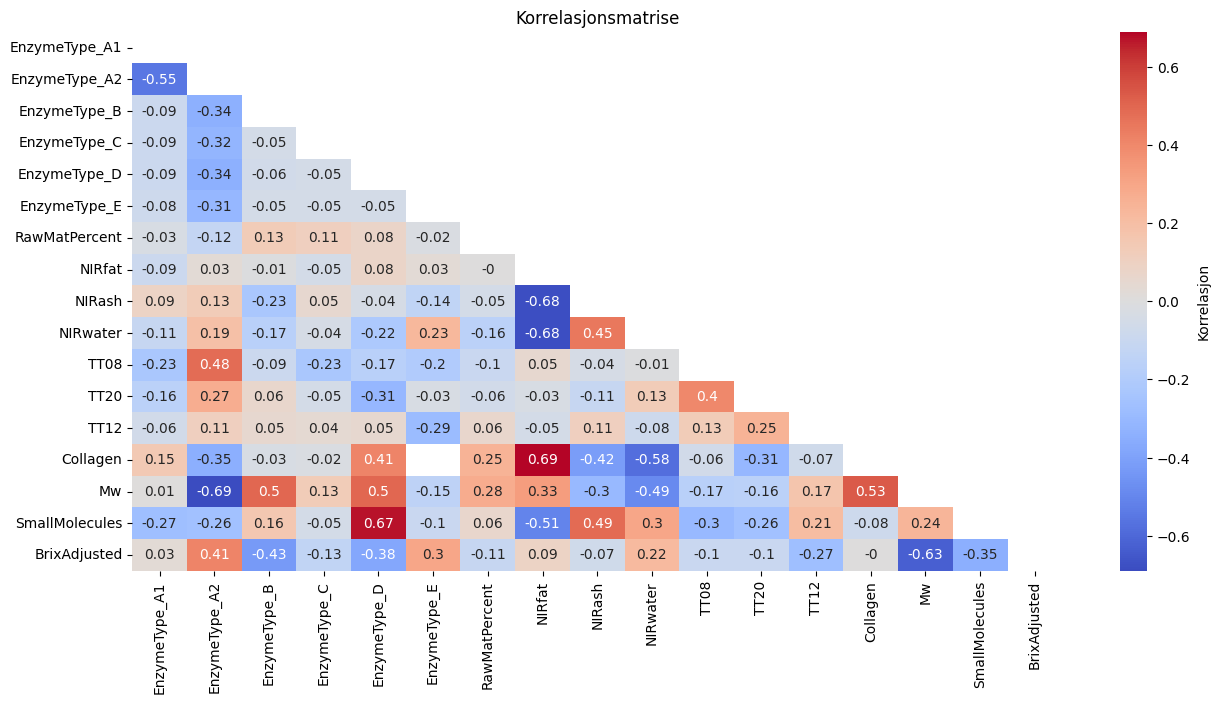

In [56]:
# Lager en korrelasjonsmatrise med annotering
korrelasjon_matrise = bioco_data.corr()

# Runder av til 2 desimaler for bedre lesbarhet
korrelasjon_matrise_avrundet = korrelasjon_matrise.round(2)

# Triangulær matrise
maske = np.triu(np.ones_like(korrelasjon_matrise_avrundet,
                             dtype=bool))

plt.figure(figsize=(15, 7))
sns.heatmap(korrelasjon_matrise_avrundet,
            annot=True,
            mask=maske,
            cmap='coolwarm',
            cbar_kws={'label': 'Korrelasjon'})
plt.title("Korrelasjonsmatrise")
plt.show()

Utelukking av variabler etter vurdering av korrelasjon

In [52]:
# Dropper kolonner "RawMatFlow" og "WaterFlow" som er høyt korrelert med
# RawMatPercent
bioco_data.drop(columns=['RawMatFlow','WaterFlow'],
                inplace = True)

# Dropper kolonne "NIRprotein" som er høyt korrelert med NIRfat
bioco_data.drop(columns=['NIRprotein'],
                inplace = True)

# Dropper kolonne "TT07", som er tilnærmet lik konstant verdi
bioco_data.drop(columns=['TT07'],
                inplace = True)

# Dropper kolonne "PT03" som er høyt korrelert med RawMatPercent og
# en direkte konsekvens av flow
bioco_data.drop(columns=['PT03'],
                inplace = True)

# Dropper kolonne "TT09" som er høyt korrelert med TT20
bioco_data.drop(columns=['TT09'],
                inplace = True)

# Førbehandlet datasett

Informasjon om de gjenverende kolonner etter behandling

In [54]:
bioco_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43251 entries, 2022-10-31 15:30:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   43251 non-null  uint8  
 1   EnzymeType_A2   43251 non-null  uint8  
 2   EnzymeType_B    43251 non-null  uint8  
 3   EnzymeType_C    43251 non-null  uint8  
 4   EnzymeType_D    43251 non-null  uint8  
 5   EnzymeType_E    43251 non-null  uint8  
 6   RawMatPercent   43196 non-null  float64
 7   NIRfat          29064 non-null  float64
 8   NIRash          29275 non-null  float64
 9   NIRwater        29293 non-null  float64
 10  TT08            43206 non-null  float64
 11  TT20            43226 non-null  float64
 12  TT12            43251 non-null  float64
 13  Collagen        99 non-null     float64
 14  Mw              540 non-null    float64
 15  SmallMolecules  540 non-null    float64
 16  BrixAdjusted    540 non-null    float64
d

Korrelasjonsmatrise

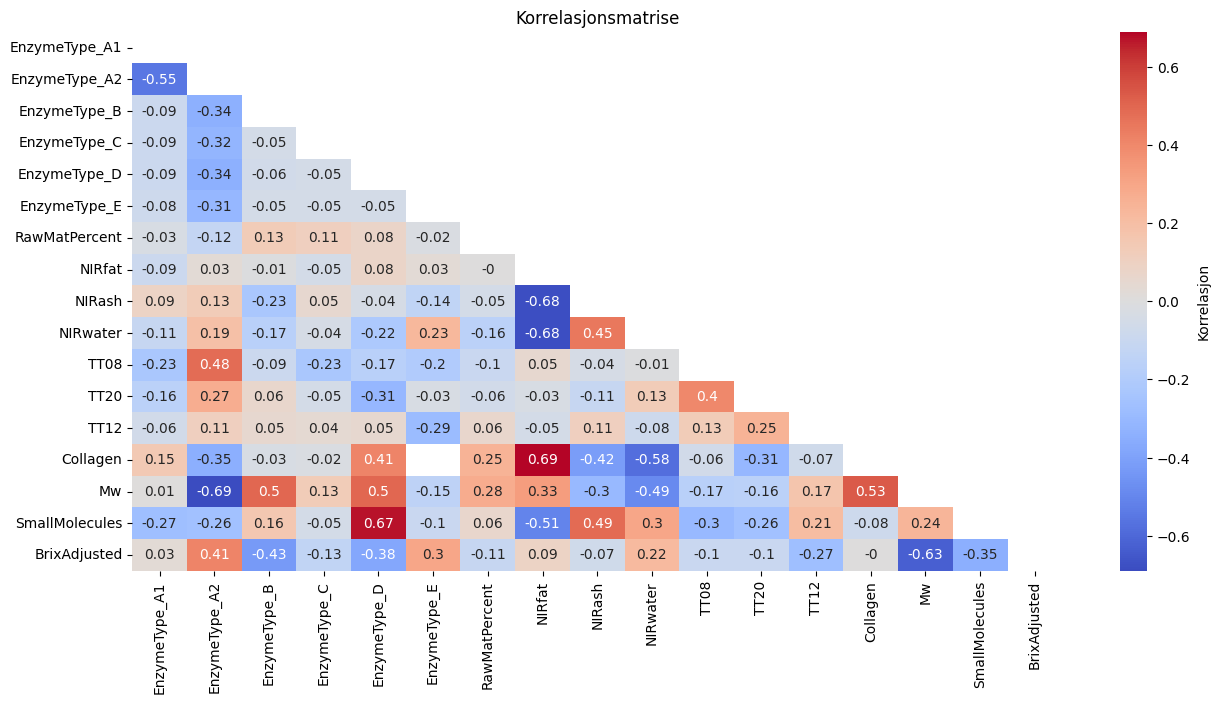

In [57]:
# Lager en korrelasjonsmatrise med annotering
korrelasjon_matrise = bioco_data.corr()

# Runder av til 2 desimaler for bedre lesbarhet
korrelasjon_matrise_avrundet = korrelasjon_matrise.round(2)

# Triangulær matrise
maske = np.triu(np.ones_like(korrelasjon_matrise_avrundet,
                             dtype=bool))

plt.figure(figsize=(15, 7))
sns.heatmap(korrelasjon_matrise_avrundet,
            annot=True,
            mask=maske,
            cmap='coolwarm',
            cbar_kws={'label': 'Korrelasjon'})
plt.title("Korrelasjonsmatrise")
plt.show()

Lagre førbehandlet data som csv

In [58]:
bioco_data.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/førbehandlet_bioco_data.csv')